# Assignment 3 - Unsupervised Learning
by Bryan Carr
30 May 2022
University of San Diego
for USD AAI 510


In this assignment, we will apply three unsupervised learning methods: Principal Component Analysis (PCA); K-Means Clustering; and Agglomerative Clustering. We will once again be using the Home Credit dataset from Kaggle.com, found at:
https://www.kaggle.com/competitions/home-credit-default-risk/data



# Initial Setup and Importing

I will begin by importing the key Python libraries to be used.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans


In [3]:
## Next we will read in our dataset

application_df = pd.read_csv('data/application_train.csv')

In [4]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
application_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



## Question 1 - PCA

### Create a PCA in Python and determine the top 10 principal components. Visualize the PCA. What does this tell you about the density of the data?

PCA will compress our data into a new set of variables, which 'point to the largest directions or orthogonal variance' (Watt, 2020). This is similar to determining the data's eigen vectors and re-casting the data into this new eigen vector space. This could be used to identify the most-contributing variables in the data, or to reduce the dimensionality of the data before applying other ML methods (remove the Target data, use PCA to create a new lower dimensional set, and then run traditional Classification methods).

PCA requires centered data, and is sensitive to scaling. Therefore we will use ScikitLearn's StandardScaler to scale the data around the origin.

For simplicity's sake, I will aim to slim down our data set by dropping the categorical and room-based variables, as well as rows with Null entries. This will give us a much smaller dataset to run this demonstration of PCA on.


In [6]:
q1_data_df = application_df.drop('SK_ID_CURR', axis=1) #drop Label column
q1_data_df = q1_data_df.drop(q1_data_df.columns[43:90], axis=1) #drop sparse columns with building info
q1_data_df = q1_data_df.select_dtypes(exclude=['object']) #drop Categorical columns
q1_data_df.dropna(axis=0, inplace=True)

In [7]:
q1_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40956 entries, 6 to 307497
Data columns (total 62 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       40956 non-null  int64  
 1   CNT_CHILDREN                 40956 non-null  int64  
 2   AMT_INCOME_TOTAL             40956 non-null  float64
 3   AMT_CREDIT                   40956 non-null  float64
 4   AMT_ANNUITY                  40956 non-null  float64
 5   AMT_GOODS_PRICE              40956 non-null  float64
 6   REGION_POPULATION_RELATIVE   40956 non-null  float64
 7   DAYS_BIRTH                   40956 non-null  int64  
 8   DAYS_EMPLOYED                40956 non-null  int64  
 9   DAYS_REGISTRATION            40956 non-null  float64
 10  DAYS_ID_PUBLISH              40956 non-null  int64  
 11  OWN_CAR_AGE                  40956 non-null  float64
 12  FLAG_MOBIL                   40956 non-null  int64  
 13  FLAG_EMP_PHONE 

We are down to ~40.9k data points, from ~307.5k - a huge reduction (leaving behind only 13% of our original rows which are full). This would normally be quite bad for analysis as we are looking at such a small subset of the original data - it would be inappropriate to draw conclusions from this. However, for illustrative purposes in the assignment, it will help speed up computation by reducing the size of input data.

We have removed all Nulls and therefore have nothing to impute. The next step will be to apply our Scaler.  First, we will split off our Target variable as Y.

In [8]:
q1_Y = q1_data_df.loc[:,'TARGET']
q1_data_df.drop('TARGET', axis=1, inplace=True)

q1_data_df.head() #Print new header for verification

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,-13778,-3130,-1213.0,-619,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
15,0,157500.0,299772.0,20160.0,247500.0,0.020713,-8728,-1157,-3494.0,-1368,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
21,1,202500.0,1132573.5,37561.5,927000.0,0.025164,-14815,-1652,-2299.0,-2299,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
28,0,270000.0,790830.0,57676.5,675000.0,0.046220,-9994,-1796,-4668.0,-2661,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
51,1,540000.0,675000.0,34596.0,675000.0,0.026392,-18632,-6977,-3904.0,-1937,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,3.0


In [9]:
q1_data_scaled = StandardScaler().fit_transform(q1_data_df)

q1_data_scaled[:5] #Print Header for verification

array([[ 4.93511869e-01, -2.58515306e-01,  1.99318249e+00,
         6.77500065e-01,  1.90563585e+00,  9.87107282e-01,
         1.74402807e-01, -2.55469336e-01,  9.84932027e-01,
         1.58096131e+00,  4.29015769e-01,  0.00000000e+00,
         2.45549613e-01, -5.27066008e-01,  4.94734364e-02,
         1.57508003e+00, -3.47993262e-01,  6.08850614e-01,
        -8.31262948e-02, -4.08711649e-02,  1.14790488e+00,
        -1.26194250e-01, -2.62170488e-01, -2.38540892e-01,
        -3.01896673e-01, -6.13510128e-01, -5.32848380e-01,
         1.38424863e+00,  1.04336305e+00, -1.41508703e-02,
        -1.87490457e-01, -3.16690500e-01, -1.81753105e-01,
        -2.70967355e-01, -5.55010794e-01,  0.00000000e+00,
        -1.46702381e+00, -6.98822428e-03, -1.16454588e-01,
        -1.64806665e-01, -1.48255294e-02,  2.22163277e+00,
        -5.44347716e-02, -4.94136045e-03, -6.20333260e-02,
        -6.98822428e-03, -1.07280075e-01,  1.60690756e+01,
        -6.08319562e-02, -1.03369676e-01, -1.30745687e-0

In [10]:
## Now let's run PCA with 10 components:

pca = PCA(n_components=10) #build the model

data_pca = pca.fit_transform(q1_data_scaled)

data_pca


array([[ 3.33185486,  1.26707988,  1.57949606, ..., -0.86827178,
         2.17947818,  1.9764468 ],
       [-3.22942544,  0.1720014 , -1.37534579, ..., -0.84246142,
         0.29257317,  0.07841228],
       [-0.0370213 ,  0.0351991 ,  1.22651753, ...,  1.41608098,
         0.13884514, -0.02947939],
       ...,
       [-0.62405269,  0.25509266,  2.2444279 , ..., -0.13923856,
         0.32858175,  0.03121655],
       [-0.52135555, -0.1960322 ,  2.9059152 , ...,  1.77265821,
         2.97893841,  0.67549729],
       [-1.68555857,  0.40101282, -1.67095649, ..., -0.49441749,
         0.86480613,  1.04969071]])

In [11]:
# Let's look at the translation of our original columns into the 10 PCA Components:

pca.components_


array([[-1.17115836e-01,  2.37459006e-01,  3.39283808e-01,
         3.16133527e-01,  3.42298009e-01,  2.41829952e-01,
        -2.32436109e-01,  1.50117289e-01, -1.04906476e-01,
        -3.58668066e-02, -9.53367342e-02,  0.00000000e+00,
        -1.51817838e-01, -2.72888131e-02, -7.58730073e-03,
         7.97961037e-02,  3.88476004e-02, -9.71820621e-02,
        -2.94694990e-01, -2.95793289e-01,  1.13789917e-01,
         3.03743100e-02,  8.26893038e-02,  8.75661454e-02,
        -6.96563528e-02, -1.05329107e-01, -7.39596580e-02,
         2.48992440e-01,  2.11554961e-01,  6.47847305e-02,
        -8.71314695e-02, -6.55211510e-02, -8.68044269e-02,
        -6.47489313e-02, -6.84624273e-02,  0.00000000e+00,
        -7.93310945e-02,  1.22811946e-03,  9.80229265e-03,
         1.12954528e-01,  5.56457379e-03,  8.65745173e-02,
         2.24564815e-02, -1.28722507e-03,  1.04472116e-02,
         5.68714124e-03,  4.68767539e-02,  4.42031505e-02,
         2.22495093e-02,  1.24752708e-02,  4.44944641e-0

In [12]:
# Let's look at the Explained Variance Ratio - that is, the contribution from each new Primary Component to overall Variance in the dataset

pca.explained_variance_ratio_


array([0.06255735, 0.05657731, 0.04290969, 0.04109714, 0.03714281,
       0.0313205 , 0.02860458, 0.02467169, 0.02365825, 0.0228167 ])

In [13]:
# Those values are quite small. Let's check their sum:

sum(pca.explained_variance_ratio_)


0.37135600936272933

[Text(0.5, 0, 'Primary Component (Number)'), Text(0, 0.5, 'Variance Ratio')]

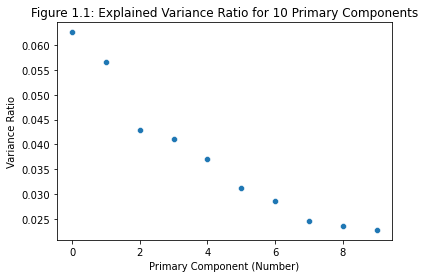

In [14]:
g1 = sns.scatterplot(
    data=pca.explained_variance_ratio_
)
g1.set_title('Figure 1.1: Explained Variance Ratio for 10 Primary Components')
g1.set(xlabel = 'Primary Component (Number)',
       ylabel='Variance Ratio')

With the top variable only contributing 6.3% to variance, and the top 10 variables only contributing 37% to it, we can see there are no strong individual contributors to information in the dataset. The sources are quite wide. Therefore this approach may not be appropriate for our data set -- we may not see strong clusters around particular areas. We may have thrown away too much information cutting out dataset down to size.

Let's look at the components in more detail, to see what the most-contributing variables are. For this purpose we'll look at the top 2 PCs only, as they are the largest contributors to overall variance.

In [15]:
pca_component_df = pd.DataFrame(pca.components_, columns=q1_data_df.columns)

pca_component_df

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,-0.117116,0.237459,0.339284,0.316134,0.342298,0.241830,-0.232436,0.150117,-0.104906,-0.035867,...,0.003478,0.007357,0.016417,-0.006124,-0.003411,0.003636,0.000688,0.057551,0.002245,-0.028945
1,0.136675,0.135280,0.089708,0.111564,0.090487,0.123382,0.292733,-0.406428,0.105808,0.070900,...,0.024775,0.007632,0.014865,0.003797,0.000672,0.002738,-0.000773,0.026794,-0.012007,-0.033278
2,0.165713,0.103491,0.355203,0.313118,0.353684,-0.134159,0.028500,-0.136009,0.088465,-0.035231,...,0.014087,0.015361,0.037227,-0.012049,-0.000491,0.000989,0.014611,0.007594,0.019824,0.005395
3,-0.074935,-0.026972,-0.136082,-0.116881,-0.135608,0.172580,-0.008861,0.066642,-0.045303,0.028894,...,0.003889,-0.008636,-0.011329,0.011211,-0.006889,-0.004074,0.005201,0.025600,-0.006524,0.043166
4,-0.170336,0.042081,0.183963,0.149292,0.182901,-0.211409,-0.109519,0.164838,-0.008909,0.014528,...,0.017148,0.004603,0.022765,-0.006423,0.002862,0.012728,0.008058,-0.034704,0.032864,0.014021
5,0.590678,-0.025485,-0.026763,-0.021762,-0.029203,0.023375,-0.046225,0.198234,0.080368,-0.239687,...,-0.020008,0.021672,-0.015695,-0.024218,-0.025940,-0.018696,-0.014630,-0.030557,-0.016784,-0.001104
6,-0.000752,0.129169,0.057041,0.073801,0.057319,-0.040348,0.165352,0.062641,0.170400,0.098987,...,0.024658,-0.012377,0.058699,0.056249,-0.002725,0.007175,0.004517,-0.036929,-0.025681,-0.069188
7,0.034819,0.111376,-0.028502,0.026822,-0.041352,0.008674,0.096628,0.065934,0.117870,0.129259,...,0.016898,0.008129,0.005747,-0.014836,0.101440,0.194974,0.180606,-0.028206,0.074766,0.057601
8,-0.051481,0.015518,0.023255,0.012263,0.015034,0.060098,0.008397,0.021263,0.018916,0.003772,...,0.036828,-0.063377,-0.022187,0.073875,-0.013759,-0.010251,-0.052884,0.046762,-0.005433,0.008040
9,0.021004,0.048033,-0.000929,0.046308,-0.000412,0.069758,0.004210,0.048691,0.046901,-0.012857,...,0.025614,-0.027002,-0.015304,-0.058596,0.350199,0.518074,0.418502,0.015366,0.023101,0.209407


In [16]:
# Slice out the first PC
# Look at Absolute Values, so negative contribution is valued fairly alongside positive
# Sort in Descending order

q1_pc1_components = pca_component_df.loc[0,:].abs().sort_values(axis=0, ascending=False)
q1_pc2_components = pca_component_df.loc[1,:].abs().sort_values(axis=0, ascending=False)


q1_pc1_components


AMT_GOODS_PRICE                0.342298
AMT_CREDIT                     0.339284
AMT_ANNUITY                    0.316134
REGION_RATING_CLIENT_W_CITY    0.295793
REGION_RATING_CLIENT           0.294695
                                 ...   
FLAG_DOCUMENT_10               0.001287
FLAG_DOCUMENT_4                0.001228
AMT_REQ_CREDIT_BUREAU_WEEK     0.000688
FLAG_DOCUMENT_2                0.000000
FLAG_MOBIL                     0.000000
Name: 0, Length: 61, dtype: float64

We can see a clear top 10, with a drop to ~15% value for variables 11 and 12 (Flag_Emp_Phone and Days_Employed), and another drop to ~11% after that. Let's plot the top 15 to visualize this.

<function matplotlib.pyplot.show(close=None, block=None)>

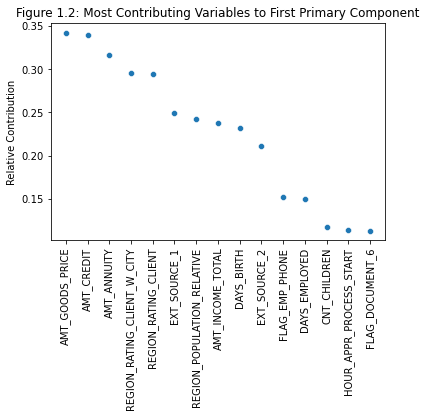

In [17]:
comp1_plot = sns.scatterplot(data=q1_pc1_components[0:15])

comp1_plot.set_title('Figure 1.2: Most Contributing Variables to First Primary Component')
comp1_plot.set(ylabel='Relative Contribution')
plt.xticks(rotation=90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

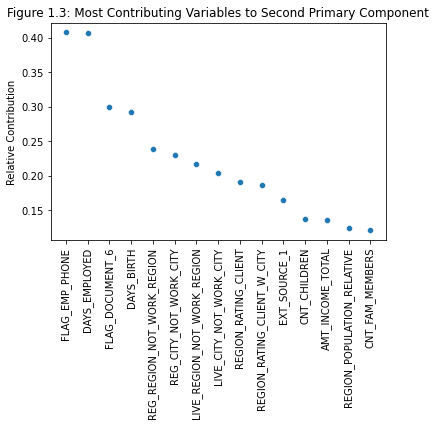

In [18]:
comp2_plot = sns.scatterplot(data=q1_pc2_components[0:15])

comp2_plot.set_title('Figure 1.3: Most Contributing Variables to Second Primary Component')
comp2_plot.set(ylabel='Relative Contribution')
plt.xticks(rotation=90)
plt.show

This shows us the 15 most important variables to each PC, which helps us understand where the PC info is coming from. These do not really match our top 10 from Assignment 2 (recall those as being ['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL']). Notably the Region Rating-type info is more of a factor here in the PCs than in the top 10 Decision Tree variables.

Lastly let's plot a sample of the first 1000 points for PC 1 vs PC 2, to see if there are any apparent groupings. I will color by the target data to help visualize the results.

In [19]:
df_pca=[] #reinitialize as blank
df_pca = pd.DataFrame(data_pca)

df_pca[0:1000]

,0,1,2,3,4,5,6,7,8,9
0,3.331855,1.267080,1.579496,-0.683314,-1.197592,-0.290392,2.280735,-0.868272,2.179478,1.976447
1,-3.229425,0.172001,-1.375346,-1.361278,1.597862,-1.569191,3.383664,-0.842461,0.292573,0.078412
2,-0.037021,0.035199,1.226518,-1.518122,-0.096780,0.101604,0.253834,1.416081,0.138845,-0.029479
3,3.981815,3.396310,-2.968487,1.203506,0.482501,-0.066060,1.827103,2.252370,-0.860793,-1.010826
4,0.852922,0.248755,1.102029,-0.216864,-0.783299,0.049232,-0.529273,1.465110,-0.395065,1.997967
...,...,...,...,...,...,...,...,...,...,...
995,1.836091,3.237260,-3.746318,1.398204,-0.607554,2.170682,1.428967,1.722800,-1.176235,-0.952865
996,-0.152974,0.671321,0.117647,-0.532502,-0.939613,-0.394056,-0.409720,-0.218434,-0.774538,-0.365119
997,-0.974777,-0.717003,1.623104,-2.331629,0.212015,0.323847,-0.907729,-1.297982,-1.515944,-0.295133
998,-2.958280,0.201702,1.715207,-0.242754,-0.183290,1.462800,3.130377,-0.688784,-1.535108,0.234621


In [20]:
sum(q1_Y[0:1000]) #Check number of Failures to Repay in top 1000 samples, to make sure we will see something

66

In [21]:
q1_Y.reset_index()

,index,TARGET
0,6,0
1,15,0
2,21,0
3,28,0
4,51,0
...,...,...
40951,307473,0
40952,307482,0
40953,307491,0
40954,307494,0


In [22]:
# Append Q1_Y to DF_PCA as Target data

df_pca['TARGET'] = q1_Y.reset_index()['TARGET']
df_pca.columns = ['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', "PC6", 'PC7', 'PC8', 'PC9', 'TARGET']
df_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,TARGET
0,3.331855,1.267080,1.579496,-0.683314,-1.197592,-0.290392,2.280735,-0.868272,2.179478,1.976447,0
1,-3.229425,0.172001,-1.375346,-1.361278,1.597862,-1.569191,3.383664,-0.842461,0.292573,0.078412,0
2,-0.037021,0.035199,1.226518,-1.518122,-0.096780,0.101604,0.253834,1.416081,0.138845,-0.029479,0
3,3.981815,3.396310,-2.968487,1.203506,0.482501,-0.066060,1.827103,2.252370,-0.860793,-1.010826,0
4,0.852922,0.248755,1.102029,-0.216864,-0.783299,0.049232,-0.529273,1.465110,-0.395065,1.997967,0
...,...,...,...,...,...,...,...,...,...,...,...
40951,-2.512504,-1.256924,0.477923,-1.418113,-0.106571,0.582716,-1.101747,-0.659977,-1.177052,-0.464267,0
40952,0.691896,0.352335,-1.126823,-0.286402,-1.402624,-1.028462,2.493448,-0.143774,0.032306,-0.214395,0
40953,-0.624053,0.255093,2.244428,0.053146,-0.745624,1.851645,-1.214254,-0.139239,0.328582,0.031217,0
40954,-0.521356,-0.196032,2.905915,3.281309,-0.540450,0.984536,-0.486846,1.772658,2.978938,0.675497,0


Text(0.5, 1.0, 'Figure 1.4: PC0 vs PC1 for first 1000 data points')

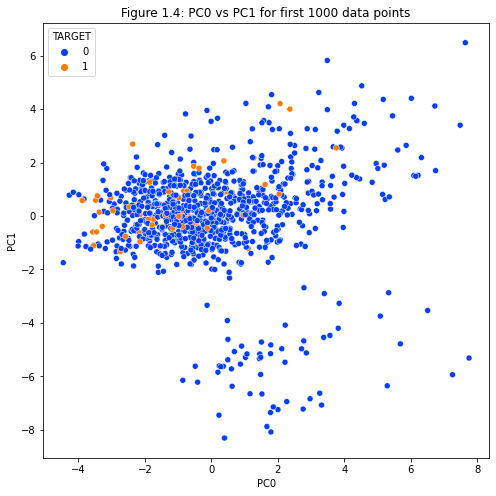

In [23]:
plt.figure(figsize=(8,8))

sns.color_palette('bright')

pc_plot = sns.scatterplot(
    data=df_pca[0:1000],
    x='PC0', y='PC1',
    hue='TARGET',
    palette='bright'
)
pc_plot.set_title('Figure 1.4: PC0 vs PC1 for first 1000 data points')


We can see in this example that there is, in fact, a small bit of clustering. Notably all the failures to make loan payments (yellow dots) are part of the main group. Unfortunately there are many more successful repayments in that central group, but this PCA approach might help us split out many of the outliers, if nothing else.


## Question 2 -- Hierarchical Clustering

### Use hierarchical clustering, visualize the tree and determine the best “cut”. What distance measure did you use? Why? Compare the branching order to the CART from module 2.

I will now move on to investigating clustering with a hierarchical approach, using an agglomerative clustering approach to build clusters from the ground up. I will use the PCA-converted data from above, to take advantage of the work done already and to help ease computational complexity. I will begin by trying a few different plotting methods, using the SciPy.Cluster.Hierarchy library, to determine what methods of clustering to use, using the first 300 data points only -- remove comments from the code boxes below to generate the test plots as desired.

In [24]:
# Test for 'Average' distance measuring Method

# plt.figure(figsize=(12,8))
# q2_dendrogram_test = sch.dendrogram(sch.linkage(df_pca.loc[0:300,'PC0':'PC9'], method='average'), truncate_mode='level', p=20)

In [25]:
# Testing for 'Complete' distance measuring method

# plt.figure(figsize=(12,8))
# q2_dendrogram_test = sch.dendrogram(sch.linkage(df_pca.loc[0:300,'PC0':'PC9'], method='complete'), truncate_mode='level', p=20)

In [26]:
# Testing for 'Single' distance measuring method

# plt.figure(figsize=(12,8))
# q2_dendrogram_test = sch.dendrogram(sch.linkage(df_pca.loc[0:300,'PC0':'PC9'], method='single'), truncate_mode='level', p=20)

In [27]:
# Testing for 'Ward' distance calculation

# plt.figure(figsize=(12,8))
# q2_dendrogram_test = sch.dendrogram(sch.linkage(df_pca.loc[0:300,'PC0':'PC9'], method='ward'), truncate_mode='level', p=20)

In [28]:
# Testing for 'Weighted' distance calculation

# plt.figure(figsize=(12,8))
# q2_dendrogram_test = sch.dendrogram(sch.linkage(df_pca.loc[0:300,'PC0':'PC9'], method='weighted'), truncate_mode='level', p=20)


In [29]:
# Testing for 'Centroid' distance calculation

# plt.figure(figsize=(12,8))
# q2_dendrogram_test = sch.dendrogram(sch.linkage(df_pca.loc[0:300,'PC0':'PC9'], method='centroid'), truncate_mode='level', p=20)

We can see that the Ward and Weighted methods look the cleanest. I will choose Weighted (WPGMA or Weighted Pair Group Mean Average) as it appears less computationally complex than the Ward method.

Now I will calculate the linkage matrix for the entire set, using this method. Then I will create two plots - one with depth 15 (similar to my tests with depth 20), and one with depth 8 (similar to the depths used in Assigment 2's Classification Trees).

In [30]:
q2_linkage_matrix = sch.linkage(df_pca.loc[:,'PC0':'PC9'], method='weighted')

q2_linkage_matrix

array([[1.13630000e+04, 2.70490000e+04, 9.64773821e-02, 2.00000000e+00],
       [8.93800000e+03, 2.73770000e+04, 1.60752096e-01, 2.00000000e+00],
       [3.08500000e+03, 2.17560000e+04, 1.93542131e-01, 2.00000000e+00],
       ...,
       [1.03340000e+04, 8.19060000e+04, 2.90969921e+01, 4.09130000e+04],
       [8.19020000e+04, 8.19080000e+04, 3.27261630e+01, 4.09420000e+04],
       [8.19070000e+04, 8.19090000e+04, 4.62803303e+01, 4.09560000e+04]])

Text(0.5, 1.0, 'Figure 2.1: Dendrogram from PCA-Reduced Data')

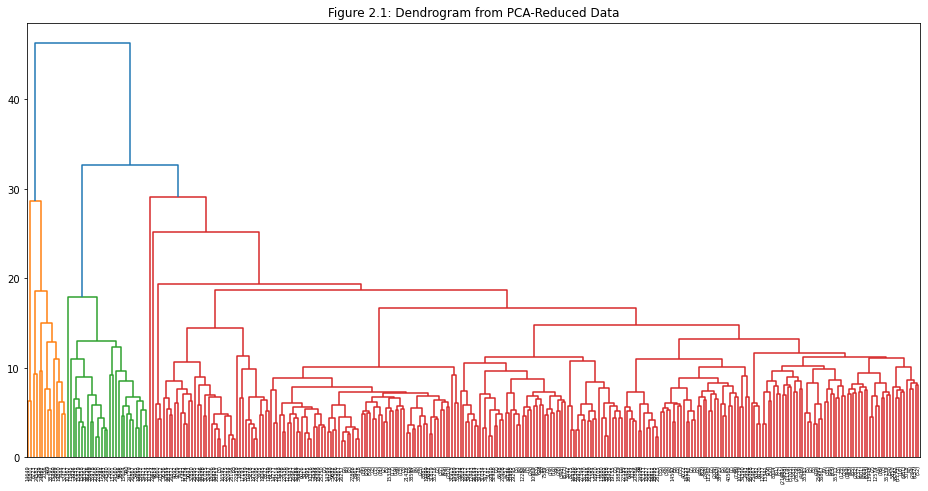

In [40]:
plt.figure(figsize=(16,8))

q2_dendrogram = sch.dendrogram(q2_linkage_matrix, truncate_mode='level', p=15)
plt.title('Figure 2.1: Dendrogram from PCA-Reduced Data')

Text(0.5, 1.0, 'Figure 2.2: Dendrogram from PCA-Reduced Data, to a Depth of 8 Levels')

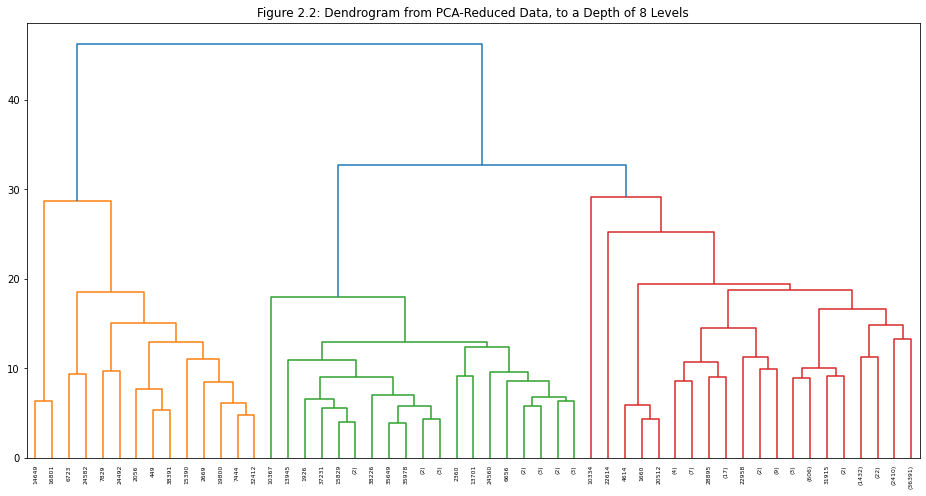

In [39]:
plt.figure(figsize=(16,8))

q2_dendrogram_8lvl = sch.dendrogram(q2_linkage_matrix, truncate_mode='level', p=8)
plt.title('Figure 2.2: Dendrogram from PCA-Reduced Data, to a Depth of 8 Levels')

We can see there are 3 major clusters. A cut of 3 at a height of 30 looks appropriate for the largest clusters, though a cut at a height around 20 would also create 6 clusters. As the left-most clusters seem to mostly represent single data points at the bottom level (with a few pairs in the green one), grouping them may not be very instructive - they are likely all outliers. Therefore making a cut deep enough to include cutting the red groups would be more instructive, around k=8 to k=10.

Compared to the regression trees, we can see there are still relevant 'decisions' being made based on what points and clusters to pair up, right down the tree. For the deeper tree, the tree is very cluttered and unreadable - a familiar feeling. The overwhelming majority of data is in the rightmost red group, and even then, the majority is within one cluster of 36,000+ points. This demonstrates the need for deep 'trees' to split the clusters up. However, it also shows that this approach has not done much to split our data up. We already saw that PC1 and PC2 had a significant grouping, so this is not surprising, but is a little disappointing.


## Question 3 - K-Means Clustering

### Cluster the same data using K-means. Why did you choose that K and type of distance? What does this tell you about the data?

I will again use our PCA data to take advantage of the reduced dimensionality. I will use K=4 thanks to the 4 clusters found above with hierarchical clustering. I will use the default algorithm/distance ('Lloyd' method), as the SKLearn documentation notes that the alternate is useful when there are clearly defined clusters, which I am skeptical of finding.


In [51]:
# initialize the model with k=3 clusters

k3_model = KMeans(n_clusters=3, random_state=123, verbose=1, algorithm='auto')

In [52]:
k3_model.fit_transform(df_pca.loc[:,'PC0':'PC9'])

Initialization complete
Iteration 0, inertia 910154.7385156419
Iteration 1, inertia 777614.8406832143
Iteration 2, inertia 770842.6810360982
Iteration 3, inertia 767673.548460809
Iteration 4, inertia 765685.35850079
Iteration 5, inertia 764137.9277356747
Iteration 6, inertia 762681.9309547355
Iteration 7, inertia 761094.5092781613
Iteration 8, inertia 759221.5853213302
Iteration 9, inertia 757910.1301716478
Iteration 10, inertia 757188.3895074491
Iteration 11, inertia 756633.0579722273
Iteration 12, inertia 756085.7841439664
Iteration 13, inertia 755230.9431291191
Iteration 14, inertia 753332.022406207
Iteration 15, inertia 749128.5515411929
Iteration 16, inertia 743082.3581016082
Iteration 17, inertia 739253.3202913449
Iteration 18, inertia 738567.120128727
Iteration 19, inertia 738395.0147491475
Iteration 20, inertia 738336.8767340358
Iteration 21, inertia 738315.6563264072
Iteration 22, inertia 738306.9985389734
Iteration 23, inertia 738300.8233980377
Iteration 24, inertia 738296.22

array([[8.93000552, 4.51812834, 6.36115188],
       [9.23751752, 6.94933199, 5.0818836 ],
       [7.25799666, 3.14924117, 2.68158868],
       ...,
       [7.91618743, 4.11692096, 3.31571234],
       [8.74626299, 6.33788267, 5.81388211],
       [7.82463598, 4.62119113, 2.7475197 ]])

In [53]:
# We can look at the centres of the clusters to get an idea of where they might be located. The first two variables are the ones of main interest, given our limitations in visualizing

k3_model.cluster_centers_


array([[ 2.22549794e+00, -5.49691707e+00, -1.37505410e+00,
         6.36123497e-01,  1.46169812e+00,  1.45959198e+00,
         4.17998479e-01,  3.38456827e-01,  1.07247861e-01,
         2.60448373e-01],
       [ 1.91159634e+00,  9.97509569e-01,  2.97902000e-01,
        -8.66898980e-02,  1.53932386e-02, -1.37314034e-01,
         1.58380862e-03, -3.98361260e-02, -3.50082043e-02,
        -3.49422244e-02],
       [-1.13797650e+00,  2.03951815e-02, -1.85004952e-02,
        -1.63853092e-02, -1.42350519e-01, -6.76496454e-02,
        -3.93326598e-02, -1.17860497e-02,  7.18716448e-03,
        -6.97761064e-03]])

In [54]:
# We can also look at the labels, in array form -- this is effectively the result

k3_model.labels_


array([1, 2, 2, ..., 2, 2, 2])

Let's visualize this by plotting vs PC1 and PC2 again, and coloring based on the Cluster Label. Once again we will use the first 1000 data points, for speed.

Text(0.5, 1.0, 'Figure 3.1: PC0 vs PC1 for first 1000 data points, Coloured by KMeans Clustering with K=3')

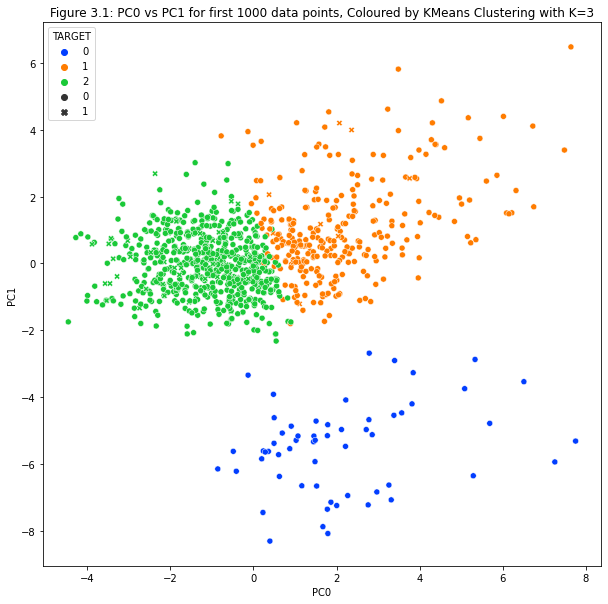

In [55]:
plt.figure(figsize=(10,10))

k3_plot = sns.scatterplot(
    data=df_pca[0:1000],
    x='PC0', y='PC1',
    hue=k3_model.labels_[0:1000],
    palette='bright',
    style=df_pca['TARGET'].loc[0:999]
)
k3_plot.set_title('Figure 3.1: PC0 vs PC1 for first 1000 data points, Coloured by KMeans Clustering with K=3')

These clusters are surprisingly clear and effective. Unfortunately (though not surprising), they do little to isolate the failures to repay loans, which are represented by an X (compared to successful loan repayments represented with a dot). This likely goes back to the basis of our exercise, where our PCA was found to not be very effective at splitting the data up, and underlies the importance of good feature selection and engineering to set a baseline for analysis.

Let's try a second value, k=6, based on the possible 6-cluster cut identified in our Hierarchical Clustering

In [56]:
k6_model = KMeans(n_clusters=6, random_state=123, verbose=1, algorithm='auto')

In [57]:
k6_model.fit_transform(df_pca.loc[:,'PC0':'PC9'])

Initialization complete
Iteration 0, inertia 735198.4390245867
Iteration 1, inertia 608077.7105760953
Iteration 2, inertia 595954.4110369033
Iteration 3, inertia 590554.8649488488
Iteration 4, inertia 581714.912349219
Iteration 5, inertia 568924.6991321408
Iteration 6, inertia 567282.1301661254
Iteration 7, inertia 566325.7038669173
Iteration 8, inertia 565174.5929783846
Iteration 9, inertia 563856.8875026144
Iteration 10, inertia 562223.828745295
Iteration 11, inertia 559719.5952843492
Iteration 12, inertia 554771.6723879486
Iteration 13, inertia 545604.46480671
Iteration 14, inertia 540640.3242112279
Iteration 15, inertia 539210.4978396179
Iteration 16, inertia 538708.9208510682
Iteration 17, inertia 538487.2824611653
Iteration 18, inertia 538361.7463678103
Iteration 19, inertia 538284.2274628687
Iteration 20, inertia 538237.3317269182
Iteration 21, inertia 538209.0529553413
Iteration 22, inertia 538191.0137050548
Iteration 23, inertia 538178.5458357126
Iteration 24, inertia 538170.5

array([[6.32445106, 8.95664801, 4.04658561, 6.23206972, 7.22457019,
        8.52729296],
       [5.39734144, 9.26438064, 7.23168369, 4.86702089, 6.93038904,
        7.87930075],
       [2.31126124, 7.28655838, 3.05028871, 3.72191922, 4.88620273,
        6.33049617],
       ...,
       [3.50087867, 7.95359714, 4.09134184, 4.07315557, 4.0338167 ,
        7.16654341],
       [6.22002204, 8.78996317, 6.36309337, 6.41482143, 4.55152473,
        8.76268805],
       [3.33558544, 7.85242549, 5.04407684, 1.83726225, 5.27373486,
        6.12253602]])

Text(0.5, 1.0, 'Figure 3.1: PC0 vs PC1 for first 1000 data points, Coloured by KMeans Clustering with K=6')

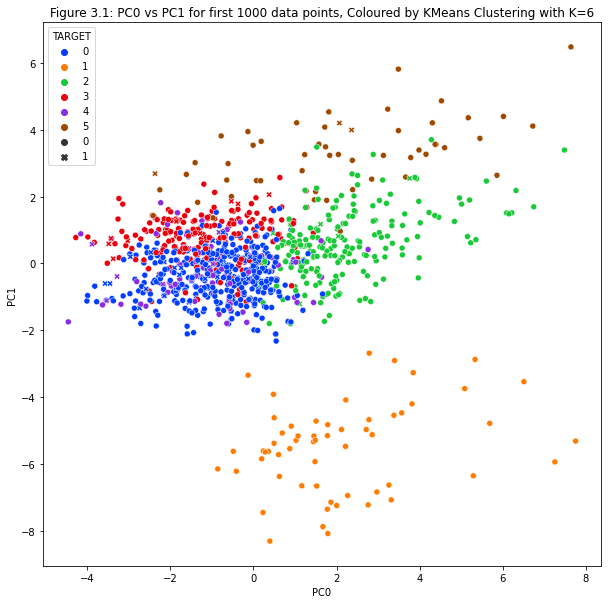

In [58]:
plt.figure(figsize=(10,10))

k6_plot = sns.scatterplot(
    data=df_pca[0:1000],
    x='PC0', y='PC1',
    hue=k6_model.labels_[0:1000],
    palette='bright',
    style=df_pca['TARGET'].loc[0:999]
)
k6_plot.set_title('Figure 3.1: PC0 vs PC1 for first 1000 data points, Coloured by KMeans Clustering with K=6')

6 Clusters may be too much, as there is some significant overlap, especially with the Purple cluster. Just for fun let's try plotting against different PCs to see if there is a better split (things should be split well in multiple dimensions)

Text(0.5, 1.0, 'Figure 3.1: PC2 vs PC3 for first 1000 data points, Coloured by KMeans Clustering with K=6')

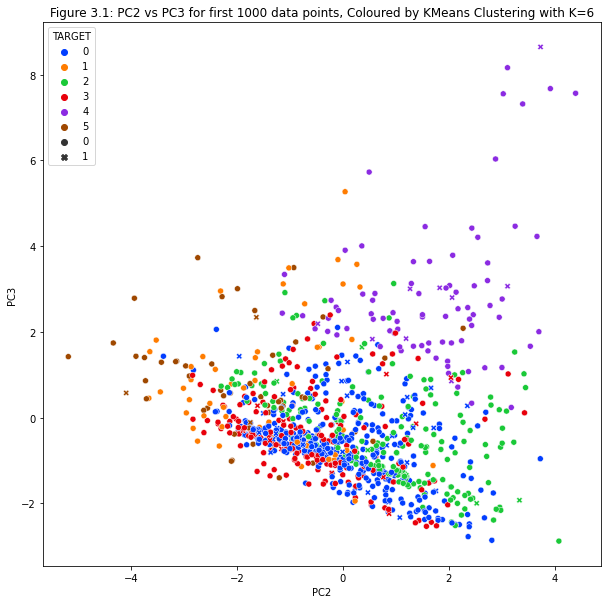

In [59]:
plt.figure(figsize=(10,10))

k6_plot_2 = sns.scatterplot(
    data=df_pca[0:1000],
    x='PC2', y='PC3',
    hue=k6_model.labels_[0:1000],
    palette='bright',
    style=df_pca['TARGET'].loc[0:999]
)
k6_plot_2.set_title('Figure 3.1: PC2 vs PC3 for first 1000 data points, Coloured by KMeans Clustering with K=6')

This is still not a clear representation for us, though interestingly we can see that the purple cluster is more separated in these dimensions. Likely we would be better off seeking fewer clusters -- k=3 gave us good results. And still, this does not seem to be very indicative of the overall classification, as our Target X's are scattered throughout the plot.